In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

# Load the data
environment_df = pd.read_csv('Dataset\Daily.csv')
energy_df = pd.read_csv('Dataset\Hourly.csv')
finance_df = pd.read_csv('Dataset\Monthly.csv')

# Display the first few rows of the data
print(environment_df.head())
print(energy_df.head())
print(finance_df.head())
print(environment_df.info())
print(energy_df.info())
print(finance_df.info())
results={}

         date   value
0  1958-03-30  316.16
1  1958-03-31  316.40
2  1958-04-02  317.67
3  1958-04-03  317.76
4  1958-04-04  317.09
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
       Date     open     high      low    close
0  1/3/2000  1469.25  1478.00  1438.36  1455.22
1  1/4/2000  1455.22  1455.22  1397.43  1399.42
2  1/5/2000  1399.42  1413.27  1377.68  1402.11
3  1/6/2000  1402.11  1411.90  1392.10  1403.45
4  1/7/2000  1403.45  1441.47  1400.73  1441.47
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18764 entries, 0 to 18763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18764 non-null  object 
 1   value   18764 non-null  float64
dtypes: float64(1), object(1)
memory usage: 293.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 12

In [3]:
def save_model(model, filename):
    filename='./model/'+filename
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

        date       value
0 1958-03-30  316.143960
1 1958-03-31  316.397080
2 1958-04-02  317.675747
3 1958-04-03  317.744391
4 1958-04-04  317.089876
             Datetime        AEP_MW
0 2004-12-31 01:00:00  13318.628600
1 2004-12-31 02:00:00  12762.652611
2 2004-12-31 03:00:00  12556.374885
3 2004-12-31 04:00:00  12562.181004
4 2004-12-31 05:00:00  12770.517001
        Date     open     high      low        close
0 2000-01-03  1469.25  1478.00  1438.36  1453.793647
1 2000-01-04  1455.22  1455.22  1397.43  1396.463452
2 2000-01-05  1399.42  1413.27  1377.68  1400.027038
3 2000-01-06  1402.11  1411.90  1392.10  1401.960166
4 2000-01-07  1403.45  1441.47  1400.73  1439.999199


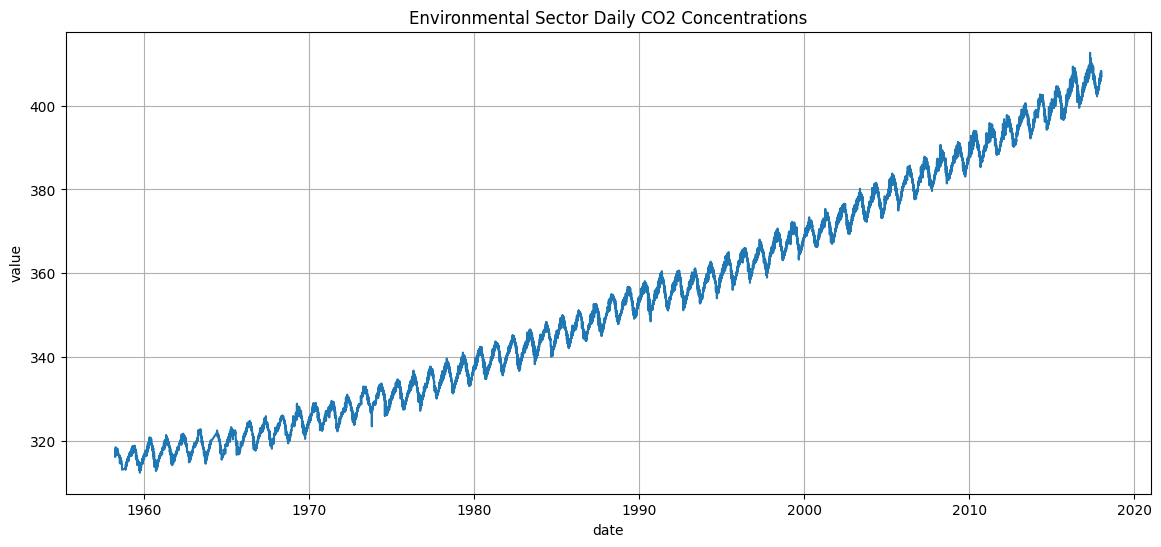

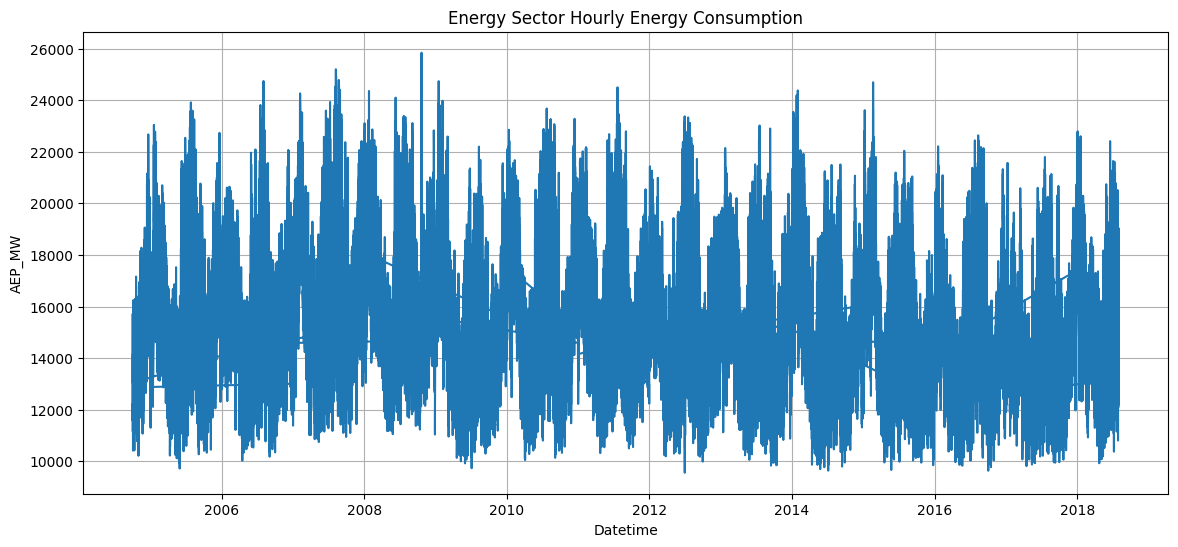

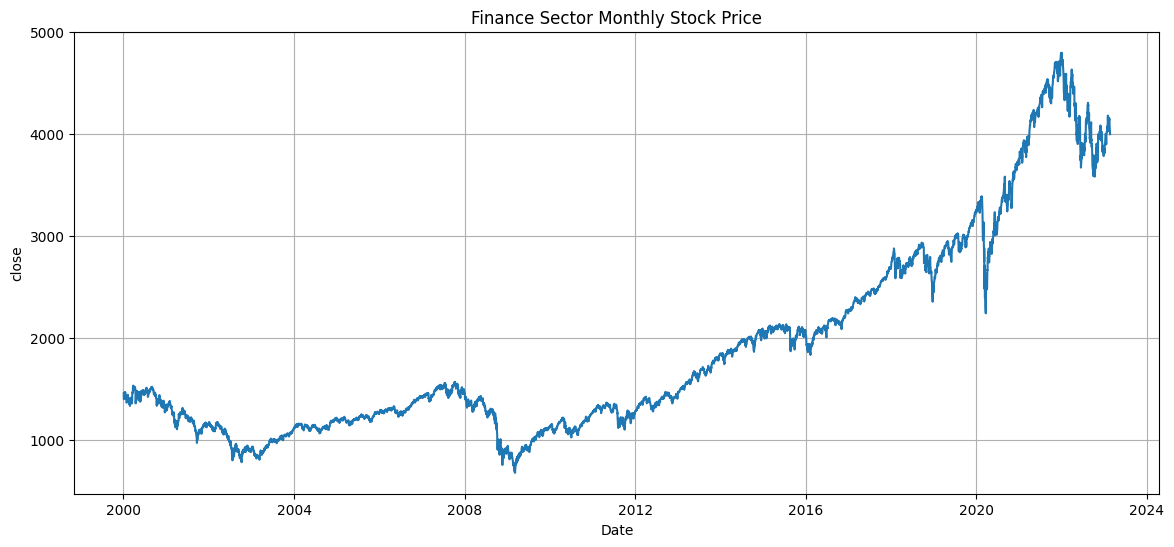

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)  # Assuming monthly data
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

def data_claning(df, date_column, value_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)
    df[value_column] = manage_seasonal_cyclic(df[value_column])
    return df

finance_df = data_claning(finance_df, 'Date', 'close')
environment_df = data_claning(environment_df, 'date', 'value')
energy_df = data_claning(energy_df, 'Datetime', 'AEP_MW')
print(environment_df.head())
print(energy_df.head())
print(finance_df.head())


def plot_graph(df, date_column, value_column, title,name):
    plt.figure(figsize=(14, 6))
    plt.plot(df[date_column], df[value_column])
    plt.title(title)
    plt.xlabel(date_column)
    plt.ylabel(value_column)
    plt.grid(True)
    plt.savefig(f'{name}.png')
    plt.show()

plot_graph(environment_df, 'date', 'value', 'Environmental Sector Daily CO2 Concentrations','environment')
plot_graph(energy_df, 'Datetime', 'AEP_MW', 'Energy Sector Hourly Energy Consumption','energy')
plot_graph(finance_df, 'Date', 'close', 'Finance Sector Monthly Stock Price',   'finance')

# 


### ARIMA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    # Split data into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    # print(fitted_model.summary())
    # Make predictions
    predictions = fitted_model.forecast(steps=len(test))
    #plot predictions  with the real values

    
    # plt.show()

    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - test)**2))
    
    return rmse,model,test,predictions

# Function to find the best ARIMA model parameters
def find_best_arima_parameters(data, p_range, d_range, q_range,name):
    best_rmse = float('inf')
    best_params = None
    best_model = None
    best_test = None
    best_predictions = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p, d, q)
                try:
                    rmse , model,test,predictions= evaluate_arima_model(data, order)
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = order
                        best_model = model
                        best_test = test
                        best_predictions = predictions
                        
                except:
                    continue
    plt.plot(best_test)
    plt.plot(best_predictions, color='red')
    plt.savefig(f'{name}_arima_model.png')
    plt.show()
    save_model(best_model, f"{name}_arima_model.pkl")
    return best_params, best_rmse



In [6]:
def armina_model_test(data, collumn_name,name):
    data = data[collumn_name].values

# Define ranges for ARIMA parameters
    p_range = range(0, 3)  # Autoregressive terms
    d_range = range(0, 3)  # Differencing
    q_range = range(0, 3)  # Moving average terms

    # Find the best ARIMA parameters
    best_params, best_rmse = find_best_arima_parameters(data, p_range, d_range, q_range,name)
    print("Best ARIMA parameters:", best_params)
    print("Best RMSE:", best_rmse)
    return best_params, best_rmse


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users

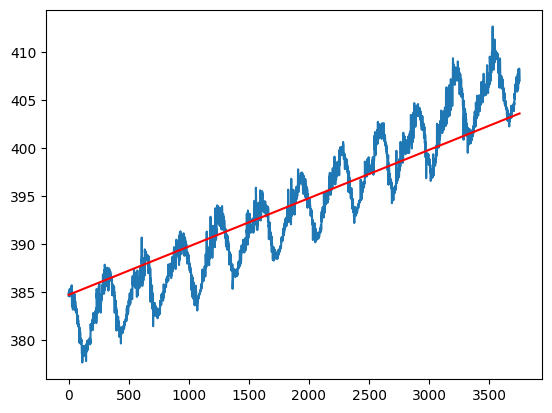

Best ARIMA parameters: (1, 2, 1)
Best RMSE: 3.1574256811829193
(1, 2, 1)
3.1574256811829193


In [10]:
best_p ,b_rmse= armina_model_test(environment_df, 'value','environment')
print(best_p)
print(b_rmse)
# results['arima_environment']=[best_p,b_rmse]

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


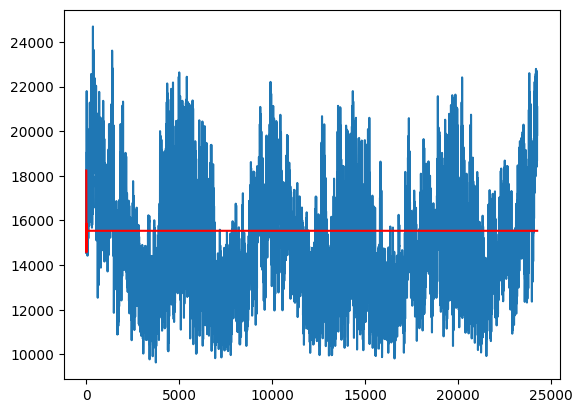

Best ARIMA parameters: (2, 1, 2)
Best RMSE: 2613.0169685956607
(2, 1, 2)
2613.0169685956607


In [11]:
best_p ,b_rmse= armina_model_test(energy_df, 'AEP_MW','energy')
print(best_p)
print(b_rmse)
# results['arima_energy']=[best_p,b_rmse]

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


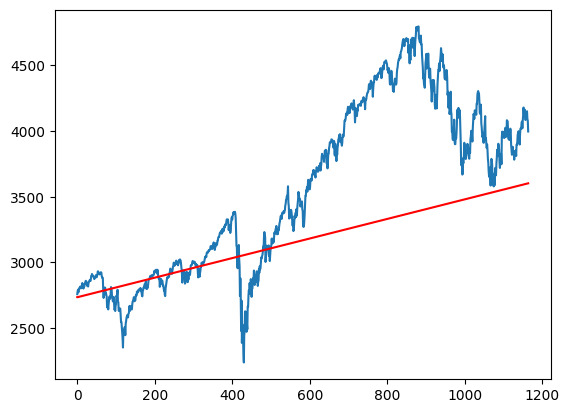

Best ARIMA parameters: (2, 2, 1)
Best RMSE: 595.6818988829195
(2, 2, 1)
595.6818988829195


In [7]:
best_p ,b_rmse= armina_model_test(finance_df, 'close','finance')
print(best_p)
print(b_rmse)
# results['arima_finance']=[best_p,b_rmse]

In [16]:
print(results)

{'arima_environment': [(1, 2, 1), 3.1574256811829193], 'arima_energy': [(2, 1, 2), 2613.0169685956607], 'arima_finance': [(2, 2, 1), 595.6818988829195], 'finance_dfarima': {'d': 1, 'p': 0.9914958358938257}, 'environment_dfarima': {'d': 1, 'p': 0.760444269150121}, 'energy_dfarima': {'d': 0, 'p': 2.3924187470182788e-29}}


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_and_order(data):
    d = 0
    adf_result = adfuller(data)
    while adf_result[1] > 0.05:
        data = np.diff(data)
        d += 1
        adf_result = adfuller(data)
    return d

# Function to check the stationarity of the data
def check_stationarity(data):
    adf_result = adfuller(data)
    return adf_result[1]

# Function to plot ACF and PACF plots
def plot_acf_pacf(data, title,name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data, ax=ax[0], lags=20)
    plot_pacf(data, ax=ax[1], lags=20)
    ax[0].set_title(f'ACF and PACF plots for {title}')
    plt.savefig(f'{name}ann_afc_pacf.png')

    plt.show()

def differnce_stationary_values(df, column, title,df_name):
    
    data = df[column].values
    print(df_name)
    # Difference the data and determine the order of differencing (d)
    d = difference_and_order(data)
    print("Order of differencing (d):", d)

    # Check the stationarity of the data
    p_value = check_stationarity(data)
    results[df_name+'arima']={"d":d,'p':p_value}
    print("ADF p-value:", p_value)
    plot_acf_pacf(data, title,df_name)


finance_df
Order of differencing (d): 1
ADF p-value: 0.9914958358938257


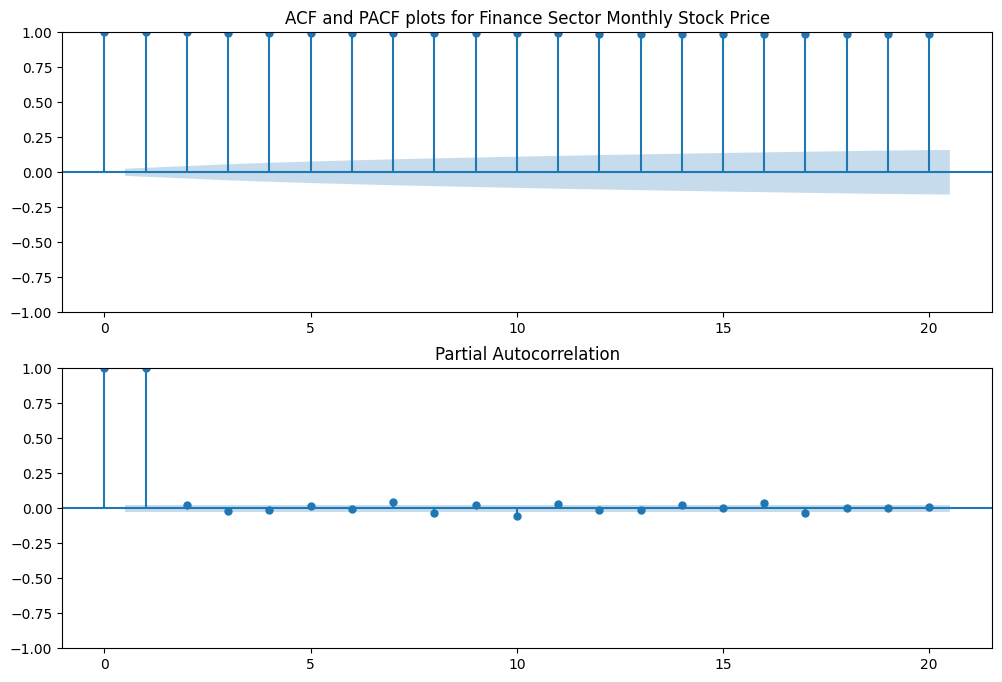

In [12]:
differnce_stationary_values(finance_df, 'close', 'Finance Sector Monthly Stock Price', 'finance_df')


environment_df
Order of differencing (d): 1
ADF p-value: 0.760444269150121


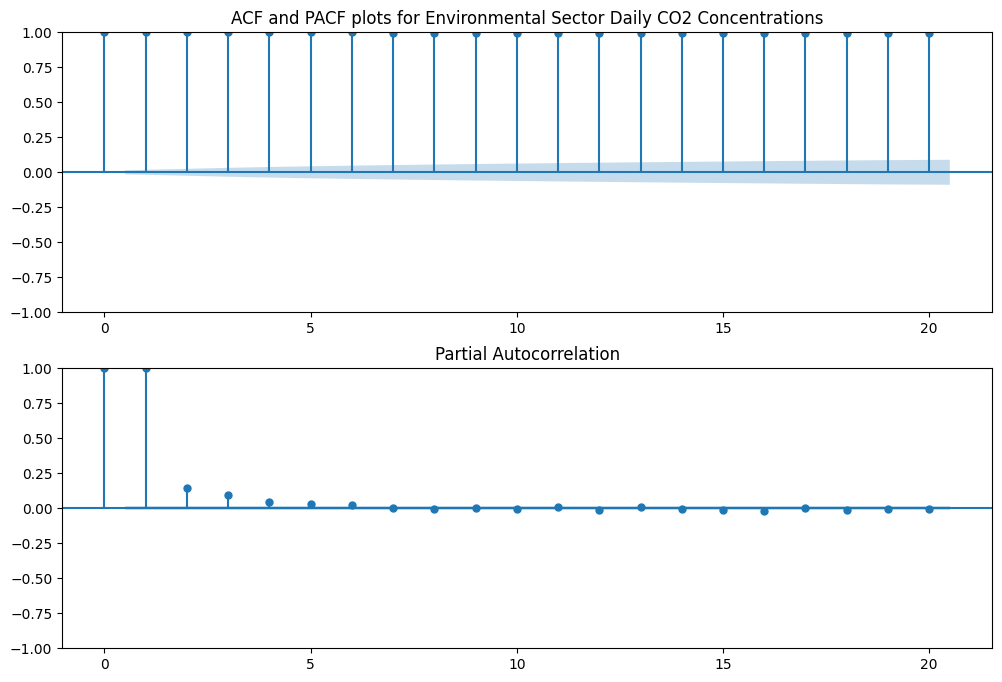

In [13]:
differnce_stationary_values(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations', 'environment_df')


energy_df
Order of differencing (d): 0
ADF p-value: 2.3924187470182788e-29


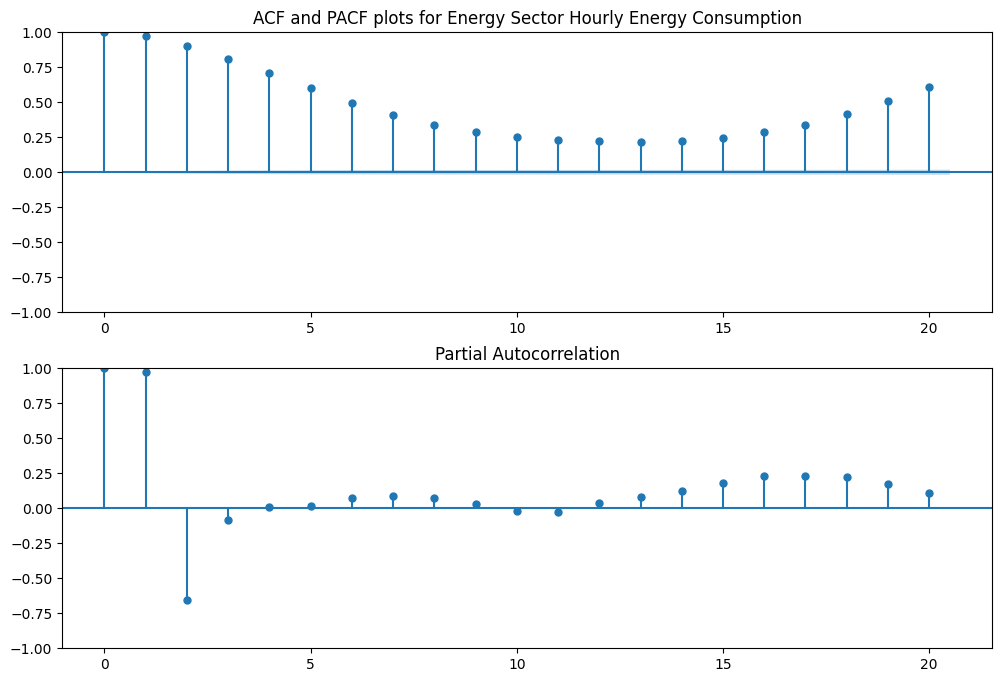

In [14]:
differnce_stationary_values(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption', 'energy_df')

### ANN

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def ann(df, x_column, y_column, name ):
    X = df[x_column].values.reshape(-1, 1)
    y = df[y_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define ANN model
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        # Dropout(0.2),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    #plot
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'{name}_ann_loss.png')
    plt.show()
    
    plt.plot(y_test)
    plt.plot(model.predict(X_test_scaled), color='red')
    plt.savefig(f'{name}_ann_model.png')
    # Evaluate the model
    loss = model.evaluate(X_test_scaled, y_test)
    results[name+'_ann']={'loss':loss}
    print(f'Test Loss: {loss}')
    # save_model(model, f"{name}_ann_model.pkl")



C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


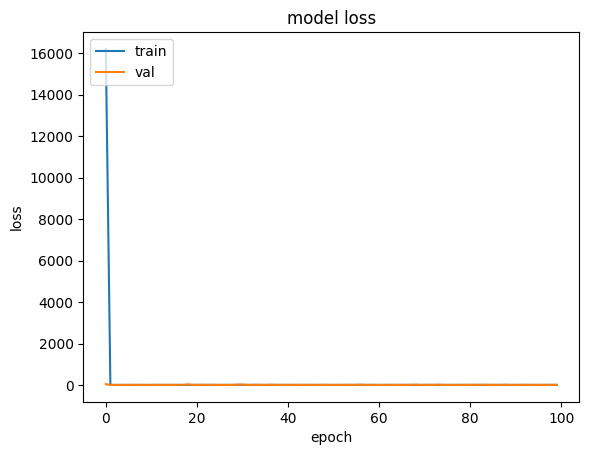

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9029
Test Loss: 18.823530197143555


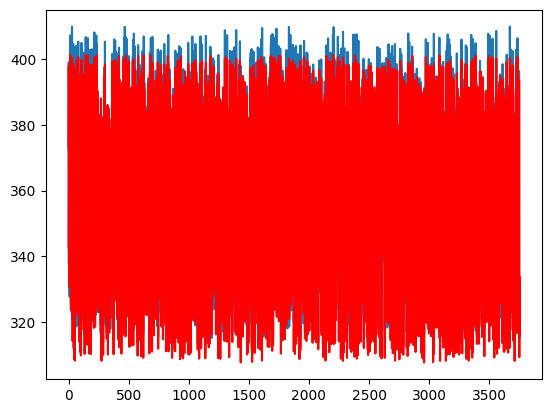

In [9]:

ann(environment_df, 'date', 'value', 'environment')

Epoch 1/100


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2426/2426 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 22214094.0000 - val_loss: 6624738.0000
Epoch 2/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6772859.5000 - val_loss: 6588511.5000
Epoch 3/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6839804.0000 - val_loss: 8782232.0000
Epoch 4/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6812746.5000 - val_loss: 6755735.0000
Epoch 5/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6739909.0000 - val_loss: 6635626.0000
Epoch 6/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6839482.0000 - val_loss: 6665440.5000
Epoch 7/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6856788.5000 - val_loss: 6625832.5000
Epoch 8/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6596816.0000 - val_loss: 6808262.0000
Epoch 9/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6658194.0000 - val_loss: 6595848.5000
Epoch 10/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6702575.5000 - val_loss: 6804426.0000


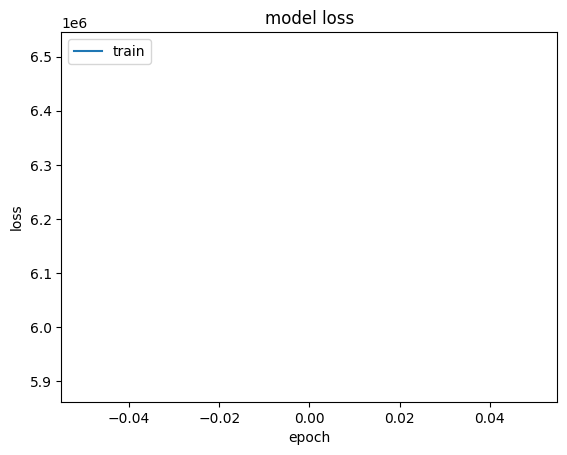

758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Loss: 6203859.0


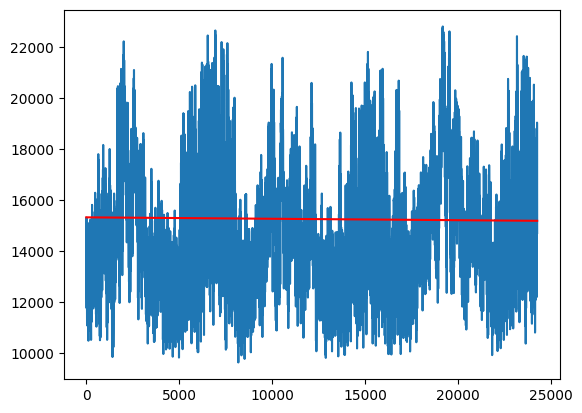

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def ann_energy(df, x_column, y_column):
    # Convert the 'Datetime' column to datetime type
    df[x_column] = pd.to_datetime(df[x_column])
    
    # Sort the DataFrame by the datetime column
    df.sort_values(by=x_column, inplace=True)
    
    # Extract the features and target variable
    X = df[[x_column]].values
    y = df[y_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define ANN model
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate the model
    loss = model.evaluate(X_test_scaled, y_test)
    #make a plot
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'energy_ann_loss.png')
    plt.show()
    
    plt.plot(y_test)
    plt.plot(model.predict(X_test_scaled), color='red')
    plt.savefig('energy_ann_model.png')
    
    # save_model(model, 'energy_ann_model.pkl')
    # results['energy_ann']={'loss':loss}
    print(f'Test Loss: {loss}')

# Call the function with the energy_df DataFrame and relevant columns
ann_energy(energy_df, 'Datetime', 'AEP_MW')


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


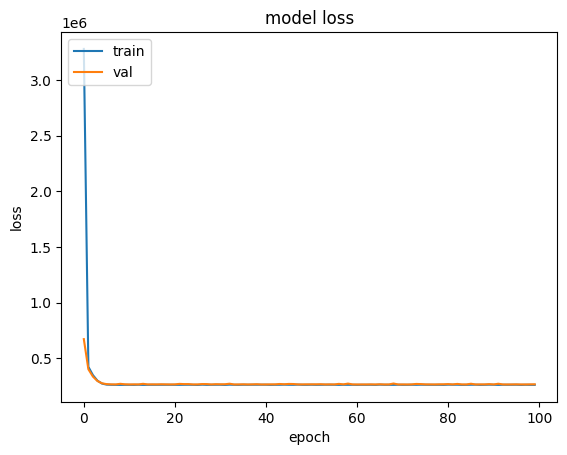

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 274076.5000 
Test Loss: 286702.75


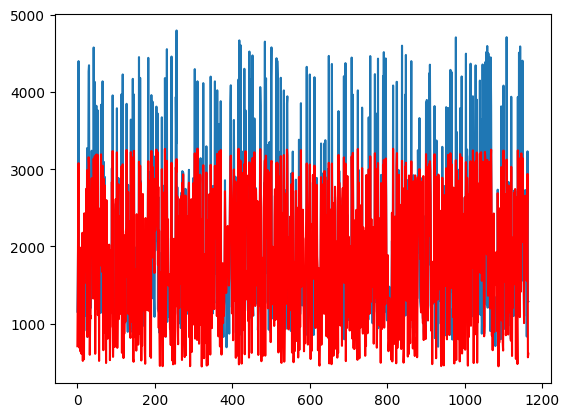

In [20]:
ann(finance_df, 'Date', 'close', 'finance')

### SARIMA

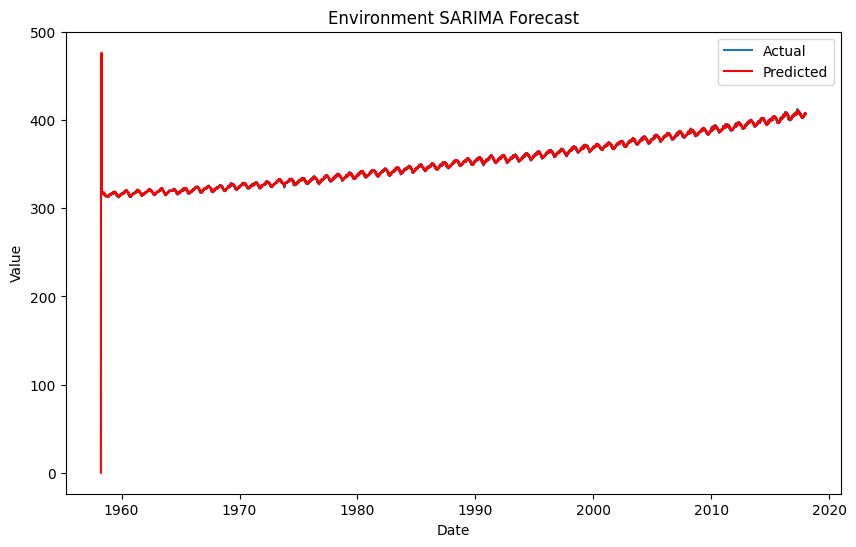

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define SARIMA parameters
# For simplicity, let's assume initial values for SARIMA parameters
# You may need to adjust these parameters based on ACF and PACF plots and statistical tests
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S)

# Fit SARIMA model for environment data
sarima_env_model = SARIMAX(environment_df['value'], order=order, seasonal_order=seasonal_order)
sarima_env_result = sarima_env_model.fit()

# Make predictions
env_forecast = sarima_env_result.predict(start=0, end=len(environment_df)-1)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(environment_df['date'], environment_df['value'], label='Actual')
plt.plot(environment_df['date'], env_forecast, label='Predicted', color='red')
plt.title('Environment SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('environment_sarima_forecast.png')

plt.show()


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_and_order(data):
    d = 0
    adf_result = adfuller(data)
    while adf_result[1] > 0.05:
        data = np.diff(data)
        d += 1
        adf_result = adfuller(data)
    return d

# Function to plot ACF and PACF plots
def plot_acf_pacf(data, title,name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data, ax=ax[0], lags=20)
    plot_pacf(data, ax=ax[1], lags=20)
    ax[0].set_title(f'ACF and PACF plots for {title}')
    plt.savefig(f'{name}_ann_afc_pacf.png')

    plt.show()

# Function to apply SARIMA model
def apply_sarima(df, column, title,pat,name):
    data = df[column].values

    # Difference the data and determine the order of differencing (d)
    d = difference_and_order(data)
    print("Order of differencing (d):", d)

    # Plot ACF and PACF plots
    plot_acf_pacf(data, title,name)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Define SARIMA model
    model = SARIMAX(train, order=(1, d, 1), seasonal_order=(1, 1, 1, pat))

    # Fit SARIMA model
    fitted_model = model.fit()

    # Forecast
    n_forecast = len(test)
    forecast = fitted_model.forecast(steps=n_forecast)
    save_model(fitted_model, f"{name}_sarima_model.pkl")

    # Plot actual vs forecast
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Training Data')
    plt.plot(range(len(train), len(train) + len(test)), test, label='Test Data')
    plt.plot(range(len(train), len(train) + len(test)), forecast, label='Forecast')
    plt.title(f'{title} - SARIMA Forecast')
    plt.legend()
    plt.savefig(f'{name}_sarima_forecast.png')
    plt.show()


Order of differencing (d): 1


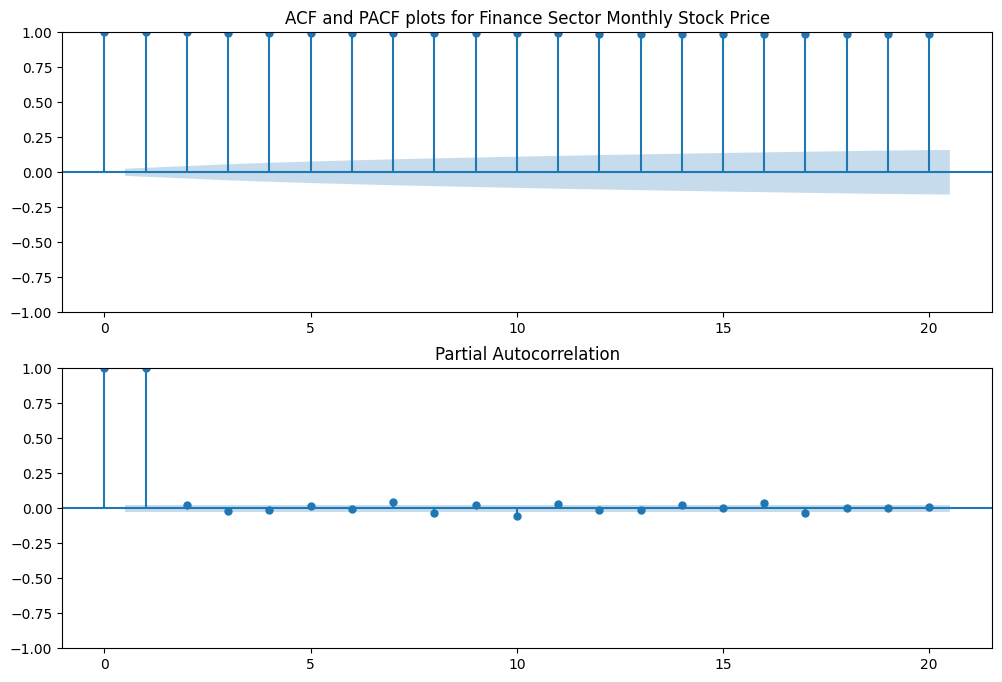

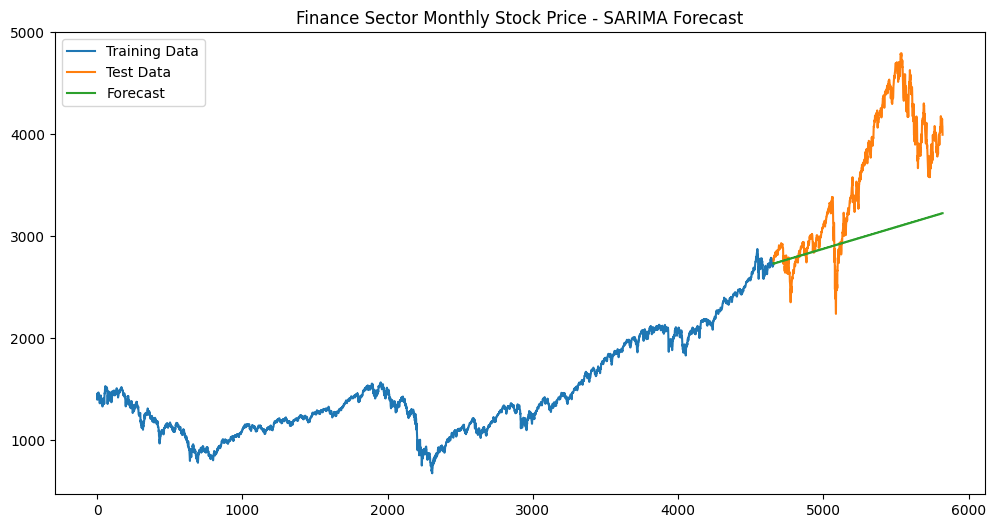

In [23]:

# Apply SARIMA model to each dataset
apply_sarima(finance_df, 'close', 'Finance Sector Monthly Stock Price', 12, 'finance')


Order of differencing (d): 1


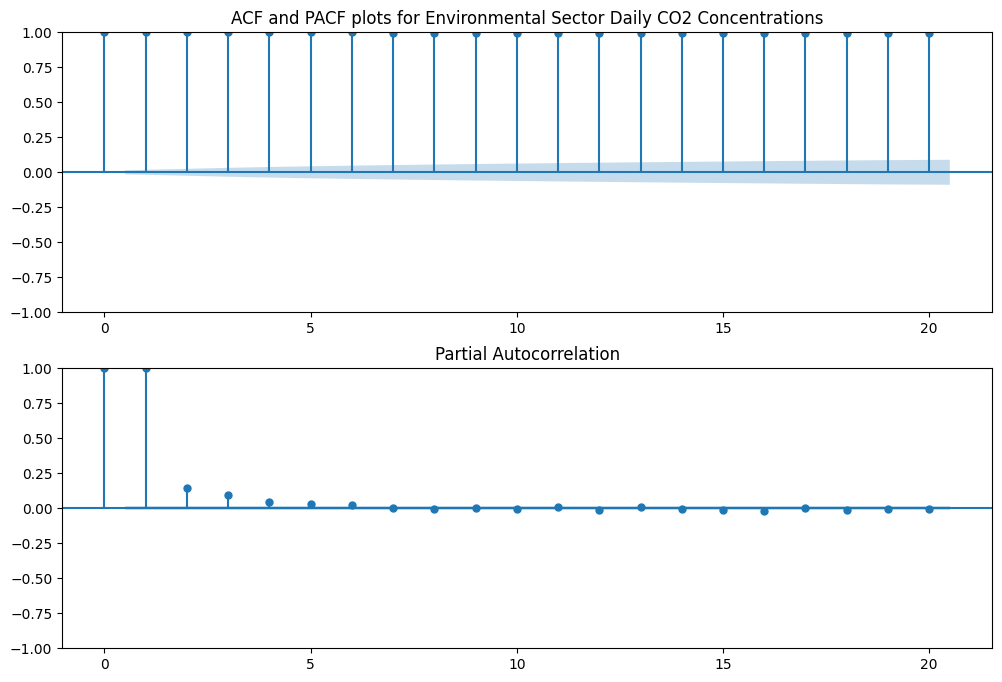

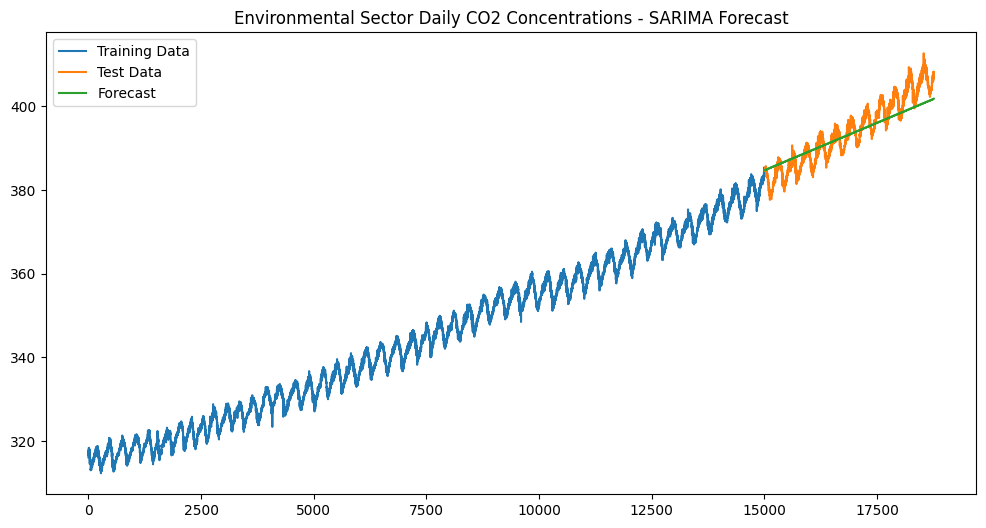

In [24]:
apply_sarima(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations', 7, 'environment')


Order of differencing (d): 0


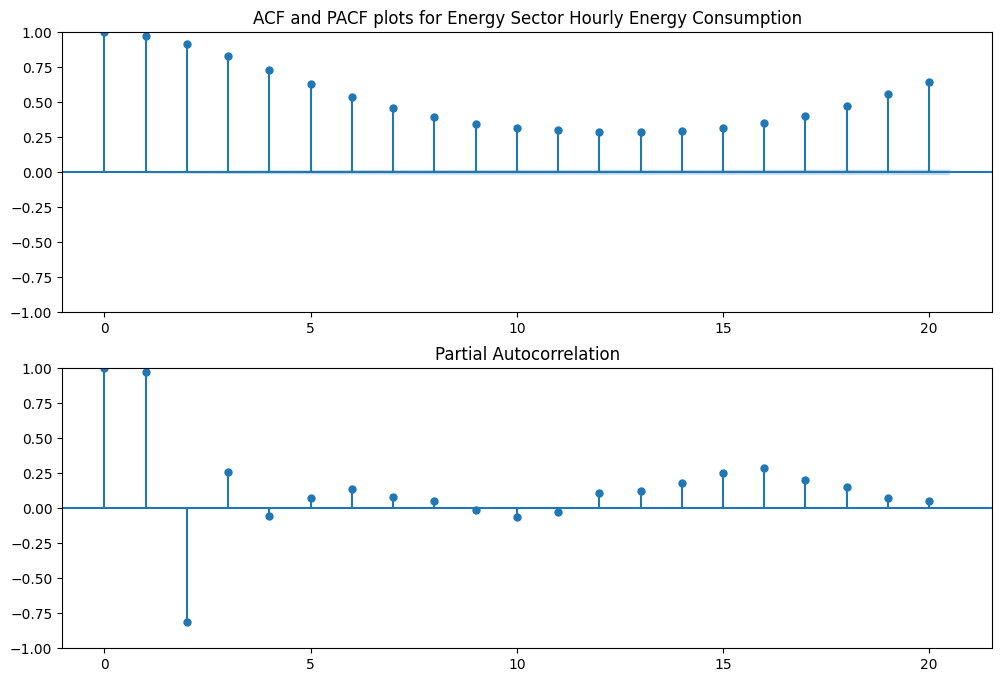

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


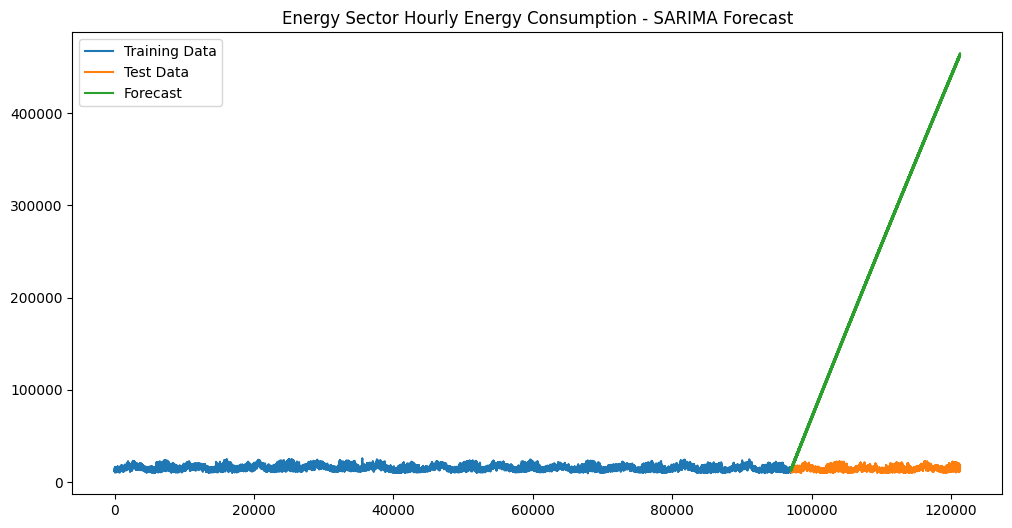

In [25]:
apply_sarima(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption', 12, 'energy')


### PROPHET

In [26]:
from prophet import Prophet

# Function to apply Prophet model
def apply_prophet(df, column, title,d,period,name):
    # Prepare the data
    data = df.rename(columns={d: 'ds', column: 'y'})
    
    # Define the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    
    # Fit the model to the data
    model.fit(data)
    
    # Make future predictions
    future = model.make_future_dataframe(periods=period)  # Forecasting for the next year
    forecast = model.predict(future)
    
    # Plot forecast
    model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(12, 6))
    save_model(model, f"{name}_prophet_model.pkl")
    plt.title(f'{name}_Prophet_Forecast')
    plt.show()


Importing plotly failed. Interactive plots will not work.


03:23:34 - cmdstanpy - INFO - Chain [1] start processing
03:23:38 - cmdstanpy - INFO - Chain [1] done processing


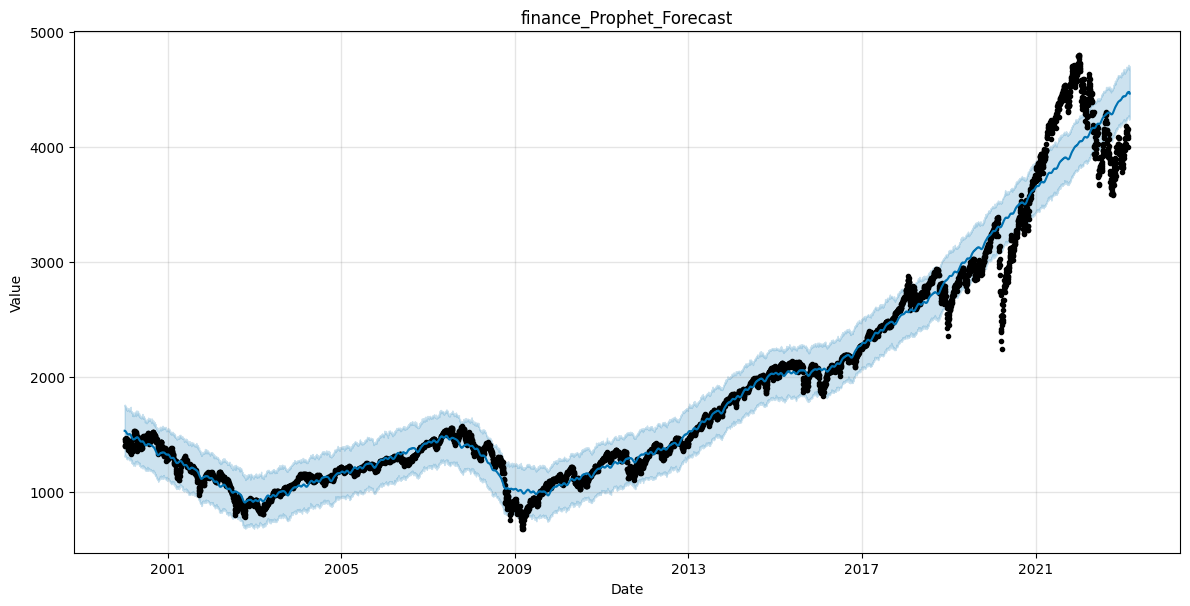

In [27]:

# Apply Prophet model to each dataset
apply_prophet(finance_df, 'close', 'Finance Sector Monthly Stock Price' ,"Date",12,'finance')


03:23:42 - cmdstanpy - INFO - Chain [1] start processing
03:24:03 - cmdstanpy - INFO - Chain [1] done processing


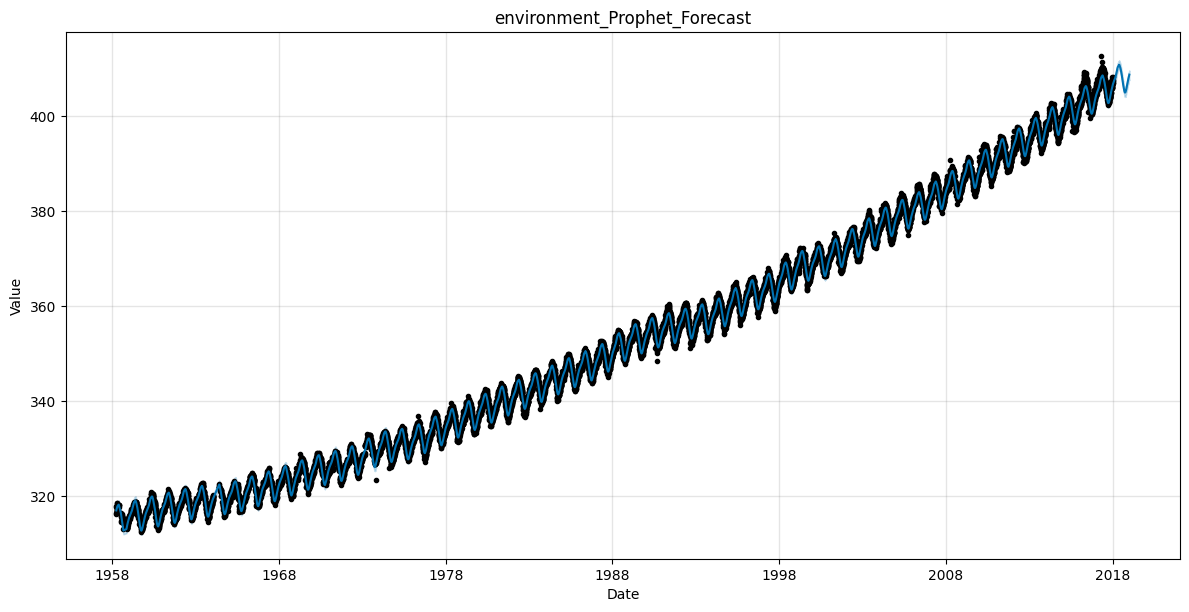

In [28]:
apply_prophet(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations','date',365,'environment')


03:24:20 - cmdstanpy - INFO - Chain [1] start processing
03:26:31 - cmdstanpy - INFO - Chain [1] done processing


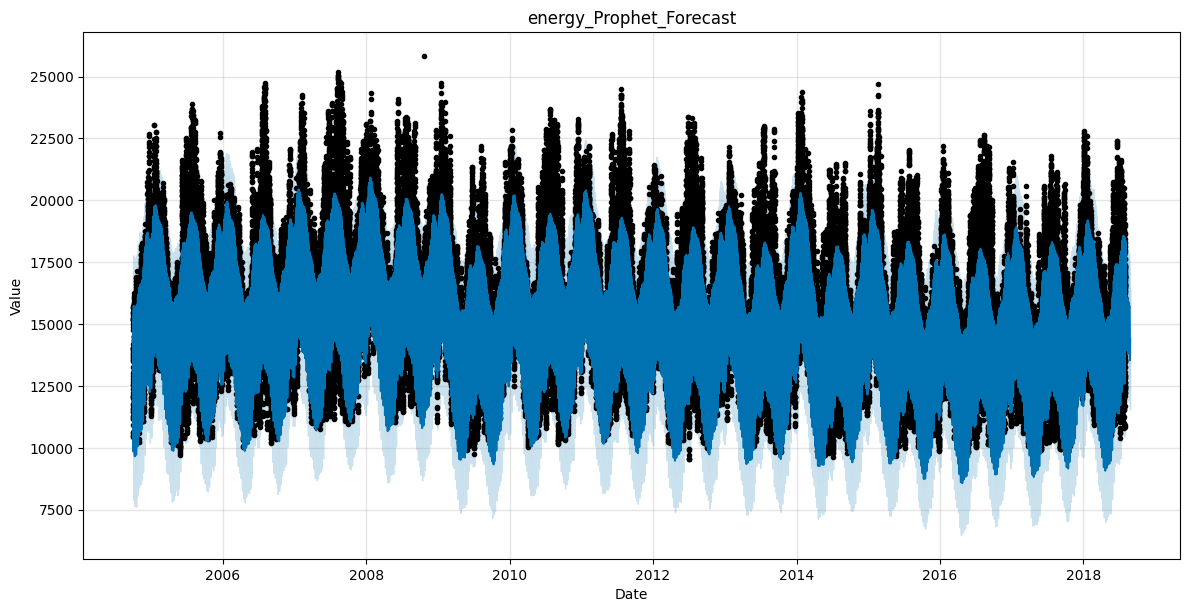

In [29]:
apply_prophet(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption','Datetime',24,'energy')


### ETS


In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Function to apply ETS model
def apply_ets(df, column, title,period,name):
    # Prepare the data
    data = df[column].values
    
    # Define and fit the ETS model
    model = ExponentialSmoothing(data,seasonal='add',trend='add',use_boxcox=True , seasonal_periods=period)  # Example: Holt-Winters with additive trend and additive seasonal component
    fitted_model = model.fit()
    
    # Make future predictions
    n_forecast = len(data)  # Forecasting for the same length as the original data
    forecast = fitted_model.forecast(steps=n_forecast)
    save_model(fitted_model, f"{name}_ets_model.pkl")
    # Plot forecast
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Actual Data')
    plt.plot(forecast, label='Forecasted Data')
    plt.title(f'{title} - ETS Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(f'{name}_ets_forecast.png')
    plt.show()


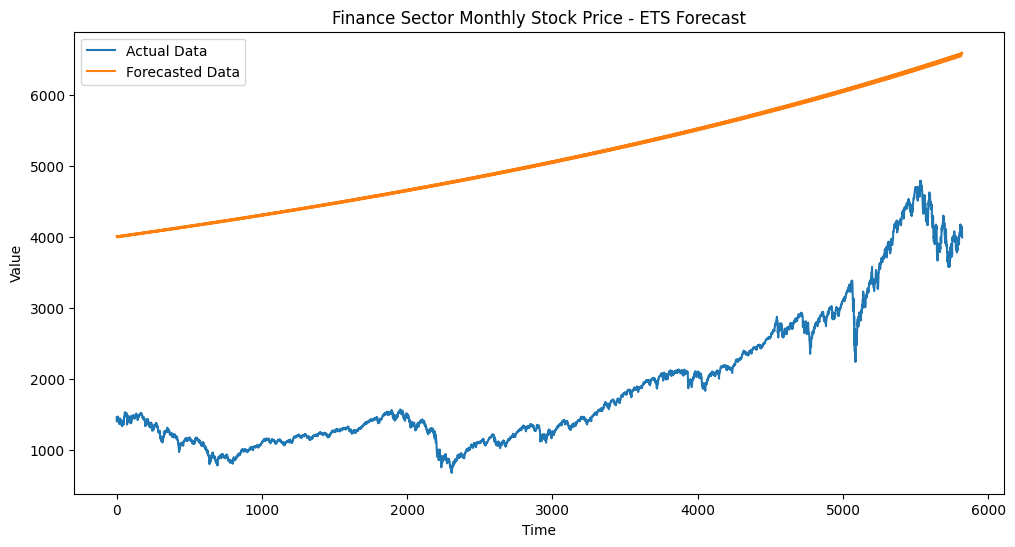

In [31]:

# Apply ETS model to each dataset
apply_ets(finance_df, 'close', 'Finance Sector Monthly Stock Price', 12,'finance')


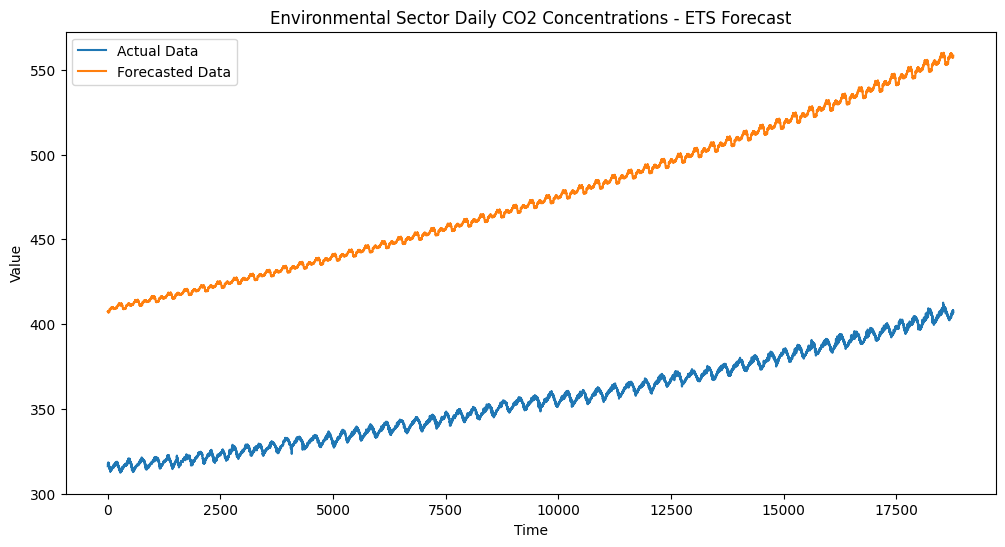

In [32]:
apply_ets(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations', 365,'environment')


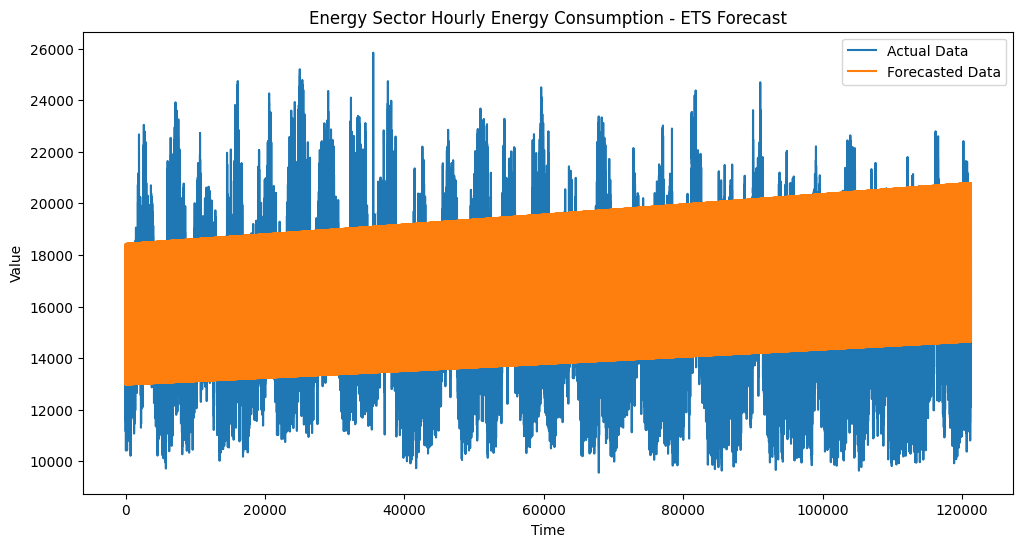

In [33]:
apply_ets(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption', 24,'energy')


### SRV

In [12]:
import pickle
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Function to save trained SVR model
def save_svr_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Function to implement SVR
def implement_svr(df, x_column, y_column, name,kernel='rbf', save_model=False):
    # Extract features and target variable
    X = df[[x_column]].values
    y = df[y_column].values
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for grid search
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': [kernel]
    }
    
    # Initialize SVR model
    svr = SVR()
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    
    # Train SVR model with best parameters
    svr_best = SVR(**best_params)
    svr_best.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = svr_best.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    #plot pred with test
    plt.plot(y_test)
    plt.plot(y_pred, color='red')
    plt.savefig(f'{name}_svr_model.png')
    plt.show()
    
    # Save trained SVR model if specified
    # if save_model:
    #     save_svr_model(svr_best, f"{name}_svr_model.pkl")
    # results[name+'_svr']={'rmse':rmse,'best_params':best_params}
    return svr_best, rmse


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.8s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END .......................C=1, gamma=scale,

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


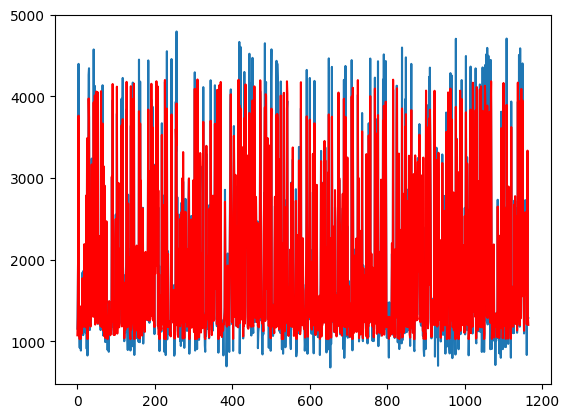

Finance Sector RMSE: 199.1997645729549


In [13]:

# Implement SVR for each dataset and save the models
svr_finance, rmse_finance = implement_svr(finance_df, 'Date', 'close', kernel='rbf', save_model=True, name='finance')
print("Finance Sector RMSE:", rmse_finance)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   8.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   9.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   9.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   9.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  10.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  10.2s
[CV] END .......................C=1, gamma=scale,

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


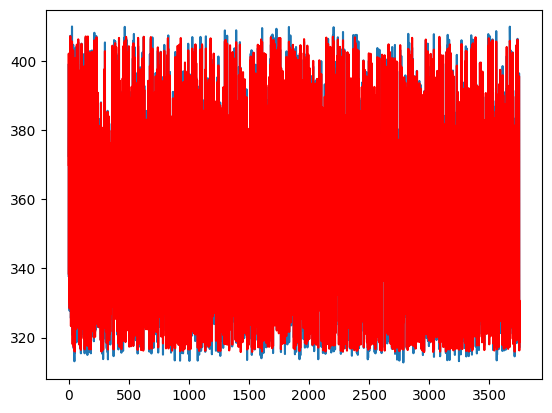

Environmental Sector RMSE: 2.230234698492288


In [14]:

svr_environment, rmse_environment = implement_svr(environment_df, 'date', 'value', kernel='rbf', save_model=True,name='enviroment')
print("Environmental Sector RMSE:", rmse_environment)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=12.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=14.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=18.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=17.9min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=16.8min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=14.2min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=15.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=18.2min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=16.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=12.0min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 9.3min
[CV] END .......................C=1, gamma=scale,

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


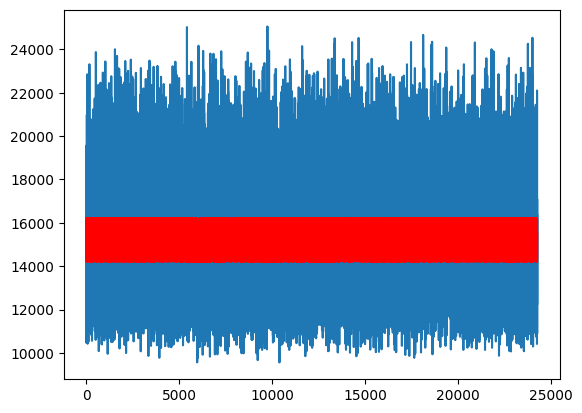

Energy Sector RMSE: 2547.015096204535


In [21]:

svr_energy, rmse_energy = implement_svr(energy_df, 'Datetime', 'AEP_MW', kernel='rbf', save_model=True,name='engery')
# Print RMSE for each dataset
print("Energy Sector RMSE:", rmse_energy)


### LSM

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Function to preprocess data and format it for LSTM
def prepare_lstm_data(df, x_column, y_column, seq_length):
    X = []
    y = []
    data = df[y_column].values
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Function to implement LSTM
def implement_lstm(df, x_column, y_column, seq_length,name, num_neurons=50, batch_size=32, epochs=100):
    # Prepare data for LSTM
    X, y = prepare_lstm_data(df, x_column, y_column, seq_length)
    
    # Split data into training, validation, and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_val, X_test = X[:train_size], X[train_size:], X[train_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:], y[train_size:]
    
    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Define LSTM model
    model = Sequential([
        LSTM(num_neurons, input_shape=(X_train_scaled.shape[1],1)),
        Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, 
              validation_data=(X_val_scaled, y_val), callbacks=[early_stopping], verbose=1)
    
    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # save_model(model, f"{name}_lstm_model.pkl")
    #plot pred with test
    plt.plot(y_test)
    plt.plot(y_pred, color='red')
    plt.savefig(f'{name}_lstm_model.png')
    plt.show()
    # results[name+'_lstm']={'rmse':rmse}    
    return model, rmse


Epoch 1/100


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2375331.7500 - val_loss: 12893755.0000
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2361507.5000 - val_loss: 12834397.0000
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2315689.7500 - val_loss: 12778904.0000
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2313293.5000 - val_loss: 12724905.0000
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2277571.7500 - val_loss: 12671851.0000
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2247641.5000 - val_loss: 12619347.0000
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2213782.0000 - val_loss: 12567242.0000
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2216501.7500 - val_loss: 12515678.0000
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2131780.5000 - val_loss: 12464381.0000
Epoch 10/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2150904.7500 - val_loss: 12413394.0000
Epoch 11/10

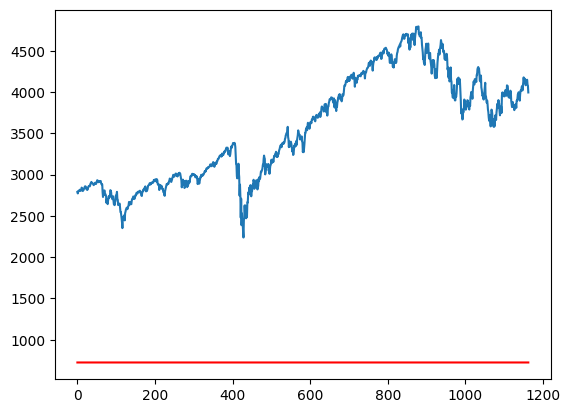

RMSE: 2897.507975531052


In [16]:

# Example usage for finance_df
lstm_model, rmse = implement_lstm(finance_df, 'Date', 'close', seq_length=10,name='finance')
print("RMSE:", rmse)
# results['finance_lstm']={'rmse':rmse,'model':'lstm_model'}

Epoch 1/100


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 111263.3750 - val_loss: 129079.7656
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 93069.0781 - val_loss: 112740.9766
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 79684.9062 - val_loss: 98203.5547
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 67625.9922 - val_loss: 85114.3594
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 56882.7383 - val_loss: 73302.8047
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 47323.6250 - val_loss: 62661.0820
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 39049.9102 - val_loss: 53103.3125
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 31675.5273 - val_loss: 44566.3867
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25247.9219 - val_loss: 36992.6211
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19733.1016 - val_loss: 30331.5352
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

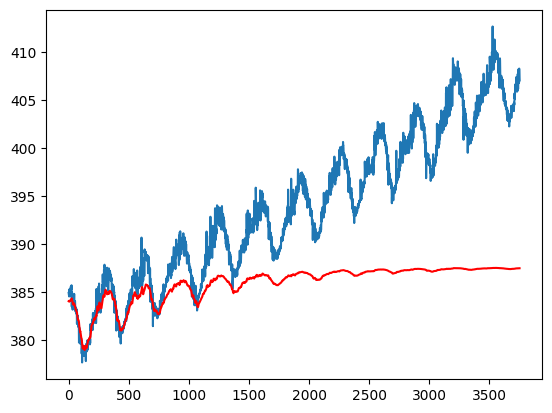

RMSE: 10.107311757526272


In [17]:
env_lstm_model, env_rmse = implement_lstm(environment_df, 'date', 'value', seq_length=10,name='enviroment')
print("RMSE:", env_rmse)
results['enviroment_lstm']={'rmse':env_rmse,'model':'env_lstm_model'}

Epoch 1/100


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3032/3032 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 251061504.0000 - val_loss: 217692624.0000
Epoch 2/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 246466704.0000 - val_loss: 213316336.0000
Epoch 3/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 242210048.0000 - val_loss: 208869360.0000
Epoch 4/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 237522672.0000 - val_loss: 204504288.0000
Epoch 5/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 232496128.0000 - val_loss: 200185056.0000
Epoch 6/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 228068768.0000 - val_loss: 195914752.0000
Epoch 7/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 223147424.0000 - val_loss: 191691952.0000
Epoch 8/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 218812336.0000 - val_loss: 187516768.0000
Epoch 9/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 214392432.0000 - val_loss: 183389824.0000
Epoch 10/100
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - lo

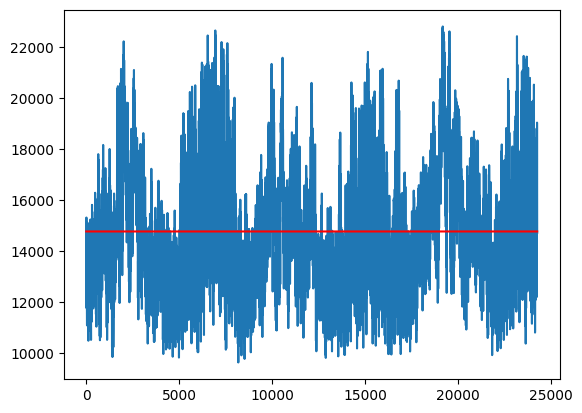

RMSE: 2430.015073092503


In [18]:
energy_lstm_model, energy_rmse = implement_lstm(energy_df, 'Datetime', 'AEP_MW', seq_length=10, name='energy')
print("RMSE:", energy_rmse)
results['energy_lstm']={'rmse':energy_rmse,'model':'energy_lstm_model'}

In [ ]:
#making plots for all lstm models to show predictions
#plot pred with test
# plt.plot(y_test)
# plt.plot(y_pred, color='red')
# plt.savefig(f'{name}_lstm_model.png')
# plt.show()
lstm_model.predict(X_test_scaled)

### HYBRID

In [ ]:
# Train ARIMA model and calculate residuals
def train_arima_model(data, order):
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(steps=len(data))
    residuals = data - predictions
    return residuals

# Train ANN model to learn from residuals
def train_ann_on_residuals(residuals, X_train, y_train, X_test, y_test):
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    loss = model.evaluate(X_test, y_test)
    return model, loss

# Function to implement hybrid ARIMA-ANN model
def hybrid_arima_ann(data, order):
    # Train ARIMA model
    residuals = train_arima_model(data, order)
    
    # Prepare data for ANN training
    X = residuals[:-1]  # Use residuals as features
    y = residuals[1:]   # Predict the next residual
    
    # Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    
    # Train ANN model on residuals
    ann_model, loss = train_ann_on_residuals(residuals, X_train, y_train, X_test, y_test)
    
    return ann_model, loss

# Example usage
# ann_model, loss = hybrid_arima_ann(finance_df['close'], (1, 1, 0))
# print("ANN Test Loss:", loss)


In [ ]:
# env_model, env_loss = hybrid_arima_ann(environment_df['value'], (1, 1, 0))

In [ ]:
# energy_model, energy_loss = hybrid_arima_ann(energy_df['AEP_MW'], (1, 1, 0))

In [ ]:
import pandas as pd
import numpy as np
#from statsmodels.tsa.statespace.sarimax import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Function to train ARIMA model and calculate residuals
def train_arima_model(data, order):
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    predictions = fitted_model.predict()
    residuals = data - predictions
    return residuals

# Function to prepare data for ANN training
def prepare_ann_data(residuals):
    X = residuals[:-1].values  # Use residuals as features
    y = residuals[1:].values    # Predict the next residual
    return X, y

# Function to train ANN model on residuals
def train_ann_model(X_train, y_train, X_test, y_test):
    #print(X_train.shape)

    model = Sequential([
        Dense(64, activation='relu', input_dim=1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    loss = model.evaluate(X_test, y_test)
    return model, loss

# Function to implement hybrid ARIMA-ANN model
def hybrid_arima_ann(data, order):
    # Train ARIMA model and calculate residuals
    residuals = train_arima_model(data, order)
    
    # Prepare data for ANN training
    X, y = prepare_ann_data(residuals)
    #print(X.shape)
    #print(y.shape)
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train ANN model on residuals
    ann_model, loss = train_ann_model(X_train, y_train, X_test, y_test)
    
    return ann_model, loss

# Example usage

#arima_order = (1, 2, 1)  # You can use the ARIMA orders obtained from your previous results
environment_arima_model, environment_arima_loss = hybrid_arima_ann(environment_df['value'], (1,2,1))
energy_arima_model, energy_arima_loss = hybrid_arima_ann(energy_df['AEP_MW'], (2,1,2))
finance_arima_model, finance_arima_loss = hybrid_arima_ann(finance_df['close'], (2,2,1))

# Print the loss of each ARIMA-ANN model
print("Environment ARIMA-ANN Loss:", environment_arima_loss)
print("Energy ARIMA-ANN Loss:", energy_arima_loss)
print("Finance ARIMA-ANN Loss:", finance_arima_loss)
# results['environment_arima_ann']={'loss':environment_arima_loss}
# results['energy_arima_ann']={'loss':energy_arima_loss}
# results['finance_arima_ann']={'loss':finance_arima_loss}
# save_model(environment_arima_model, 'environment_arima_ann_model.pkl')
# save_model(energy_arima_model, 'energy_arima_ann_model.pkl')
# save_model(finance_arima_model, 'finance_arima_ann_model.pkl')




Environment ARIMA-ANN Loss: 6.92302942276001
Energy ARIMA-ANN Loss: 86357.0078125
Finance ARIMA-ANN Loss: 672.5211181640625

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6088
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


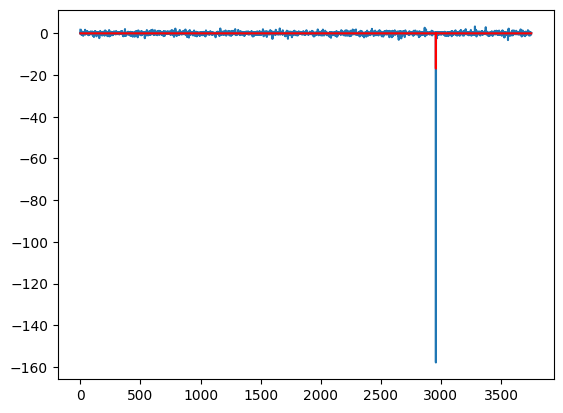

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFound

758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 88618.4531
758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


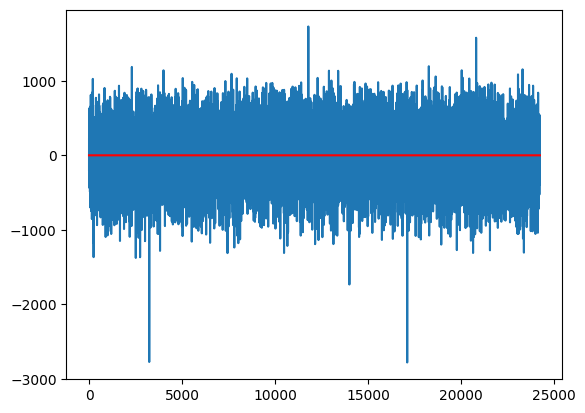

C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 724.3656
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


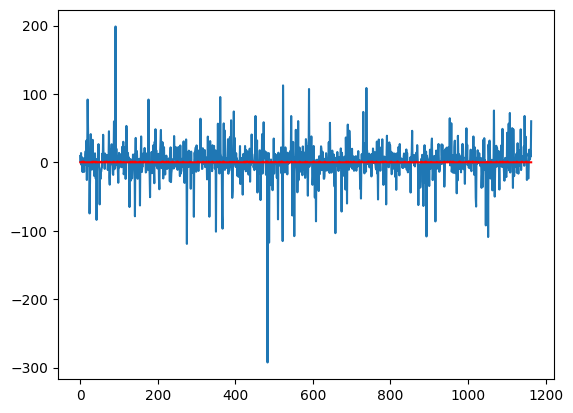

Environment ARIMA-ANN Loss: 5.568188190460205
Energy ARIMA-ANN Loss: 87662.4921875
Finance ARIMA-ANN Loss: 672.593505859375


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Function to train ARIMA model and calculate residuals
def train_arima_model(data, order):
    model = SARIMAX(data, order=order)
    fitted_model = model.fit()
    predictions = fitted_model.predict()
    residuals = data - predictions
    return residuals

# Function to prepare data for ANN training
def prepare_ann_data(residuals):
    X = residuals[:-1].values  # Use residuals as features
    y = residuals[1:].values    # Predict the next residual
    return X, y

# Function to train ANN model on residuals
def train_ann_model(X_train, y_train, X_test, y_test):
    #print(X_train.shape)

    model = Sequential([
        Dense(64, activation='relu', input_dim=1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    loss = model.evaluate(X_test, y_test)
   
    return model, loss

# Function to implement hybrid ARIMA-ANN model
def hybrid_arima_ann(data, order,name):
    # Train ARIMA model and calculate residuals
    residuals = train_arima_model(data, order)
    
    # Prepare data for ANN training
    X, y = prepare_ann_data(residuals)
    #print(X.shape)
    #print(y.shape)
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train ANN model on residuals
    ann_model, loss = train_ann_model(X_train, y_train, X_test, y_test)
    #make plot to show predicted and real values
    plt.plot(y_test)
    plt.plot(ann_model.predict(X_test), color='red')
    plt.savefig(f'{name}_sarima_ann_model.png')
    plt.show()

    return ann_model, loss

# Example usage

#arima_order = (1, 2, 1)  # You can use the ARIMA orders obtained from your previous results
environment_arima_model, environment_arima_loss = hybrid_arima_ann(environment_df['value'], (1,2,1),'environment')
energy_arima_model, energy_arima_loss = hybrid_arima_ann(energy_df['AEP_MW'], (2,1,2),'energy')
finance_arima_model, finance_arima_loss = hybrid_arima_ann(finance_df['close'], (2,2,1),'finance')

# Print the loss of each ARIMA-ANN model
print("Environment ARIMA-ANN Loss:", environment_arima_loss)
print("Energy ARIMA-ANN Loss:", energy_arima_loss)
print("Finance ARIMA-ANN Loss:", finance_arima_loss)
# results['environment_arima_ann']={'loss':environment_arima_loss}
# results['energy_arima_ann']={'loss':energy_arima_loss}
# results['finance_arima_ann']={'loss':finance_arima_loss}
# save_model(environment_arima_model, 'environment_arima_ann_model.pkl')
# save_model(energy_arima_model, 'energy_arima_ann_model.pkl')
# save_model(finance_arima_model, 'finance_arima_ann_model.pkl')




In [49]:
import json

# Save dictionary to a JSON file
with open('data.json', 'w') as f:
    json.dump(results, f)

# Load dictionary from the JSON file
with open('data.json', 'r') as f:
    loaded_data_dict = json.load(f)
    print(loaded_data_dict)


{'arima_environment': [[1, 2, 1], 3.1574256811829193], 'arima_energy': [[2, 1, 2], 2613.0169685956607], 'arima_finance': [[2, 2, 1], 595.6818988829195], 'finance_dfarima': {'d': 1, 'p': 0.9914958358938257}, 'environment_dfarima': {'d': 1, 'p': 0.760444269150121}, 'energy_dfarima': {'d': 0, 'p': 2.3924187470182788e-29}, 'environment_ann': {'loss': 15.791674613952637}, 'energy_ann': {'loss': 6079678.0}, 'finance_ann': {'loss': 292080.46875}, 'finance_svr': {'rmse': 199.1997645729549, 'best_params': {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, 'model': 'saved'}, 'enviroment_svr': {'rmse': 2.230234698492288, 'best_params': {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}, 'model': 'saved'}, 'engery_svr': {'rmse': 2547.015096204535, 'best_params': {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, 'model': 'saved'}, 'finance_lstm': {'rmse': 2910.0293792937723, 'model': 'saved'}, 'enviroment_lstm': {'rmse': 8.435306356881032, 'model': 'saved'}, 'energy_lstm': {'rmse': 2429.519522255356, 'model': 's

In [45]:
print(  results
      )
results['enviroment_svr']['model']='saved'

{'arima_environment': [(1, 2, 1), 3.1574256811829193], 'arima_energy': [(2, 1, 2), 2613.0169685956607], 'arima_finance': [(2, 2, 1), 595.6818988829195], 'finance_dfarima': {'d': 1, 'p': 0.9914958358938257}, 'environment_dfarima': {'d': 1, 'p': 0.760444269150121}, 'energy_dfarima': {'d': 0, 'p': 2.3924187470182788e-29}, 'environment_ann': {'loss': 15.791674613952637}, 'energy_ann': {'loss': 6079678.0}, 'finance_ann': {'loss': 292080.46875}, 'finance_svr': {'rmse': 199.1997645729549, 'best_params': {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, 'model': SVR(C=100, gamma='auto')}, 'enviroment_svr': {'rmse': 2.230234698492288, 'best_params': {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}, 'model': SVR(C=100)}, 'engery_svr': {'rmse': 2547.015096204535, 'best_params': {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, 'model': SVR(C=100, gamma='auto')}, 'finance_lstm': {'rmse': 2910.0293792937723, 'model': <Sequential name=sequential_3, built=True>}, 'enviroment_lstm': {'rmse': 8.435306356881032, '

In [47]:
results['engery_svr']['model']='saved'
results['finance_svr']['model']='saved'


In [48]:
results['enviroment_lstm']['model']='saved'
results['energy_lstm']['model']='saved'
results['finance_lstm']['model']='saved'